# EMSE 6586 Final Project
*DBMS for Analytics*

**Emily Parrish**

---
## Section 0: Connection and Initialization

In this project, I utilize the Python instantiations of MongoDB and Arango.  First we must: 
   1. Initialize the database instances
   2. Import helper libraries for analysis
   3. Call necessary collections for querying

In [1]:
# import all appropriate libraries
from itertools import groupby
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pymongo import MongoClient
from arango import ArangoClient

%matplotlib inline

In [2]:
# initialize Mongo client and database (code from in-class work)

client = MongoClient(host='18.219.151.47', #host is the hostname for the database
                     port=27017, #port is the port number that mongo is running on
                     username='student', #username for the db
                     password='emse6992pass', #password for the db
                     authSource='emse6992') #Since our user only exists for the emse6992 db, we need to specify this

db_mongo = client.emse6992 # our database connection

In [3]:
# initialize Arango client and database (code from in-class work)

client = ArangoClient(hosts='http://18.219.151.47:8529') # our client connection

db_arango = client.db('emse6586', username='root', password='emse6586pass') # our database connection

In [4]:
# import collections needed from MongoDB
stats_coll = db_mongo.twitter_statuses
favs_coll = db_mongo.twitter_favorites
friends_coll = db_mongo.twitter_friends
retweets_coll = db_mongo.twitter_retweets

---
## Section 1: Helper Functions

In this section, I include all plotting and sorting functions to aid with vizualization and generation of metrics in the network analysis.


In [5]:
def get_tags(rts):
    '''Takes in relavent hashtags from a Mongo query and sorts them.  Provides raw output of list of hashtags and dictionary of the frequency of each hashtag.'''

    tags = []
    tag_frq = {}
    
    # pull each hashtag and remove capitalization for grouping
    for item in rts:
        for hashtag in item["hashtags"]:
            tags.append((hashtag["text"]).lower())
    
    # sort hashtags and group them into dictionary
    for v, f in groupby(sorted(tags)):
        tag_frq[v] = len(list(f))
    
    return (tags, tag_frq)
    

In [6]:

def plot_hash_frq(out_dict, fil = 1): 
    '''Plots a bar chart of the frequency of each hashtag in a dataset.  User can also filter out lower frequency hashtags.'''
    
    filter_out = {}
    
    # filter out hashtags with frequency below x
    for key, value in out_dict.items():
        if value > fil:
            filter_out[key] = value

    x = filter_out.keys()
    y = filter_out.values()
    
    # plot bar chart
    plt.bar(x, y)
    plt.xlabel("Hashtag")
    plt.ylabel("Hashtag Frequency")
    plt.xticks(rotation=90)
    plt.show()

In [7]:
def plot_cloud(text):
    '''Combines hashtags into a single string and uses wordcloud to generate a word cloud based on frequeuncy.'''
    
    # join list to string for plotting
    text = " ".join(text)

    wordcloud = WordCloud(collocations=False, colormap='Set2').generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [8]:
def calc_retweets(name):
    '''Queries Mongo to find a user and all of their retweeted tweets, then counts the number of retweets they have'''
    
    rt = retweets_coll.find({"retweeted_status.user.screen_name" : name})
    tot_rts = 0
    for i in rt:
        tot_rts += i["retweeted_status"]["retweet_count"]

    return tot_rts

## Section 2: Hashtag Analysis and Determination

Below I have layed out three different distributions of hashtags:
1. Elon's hashtags
2. Elon's favorited statuses hashtags
3. Elon's friend network's hashtags

I use the helper functions for plotting.

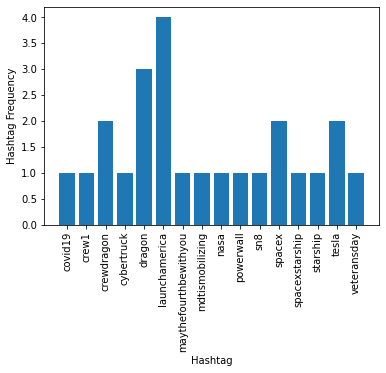

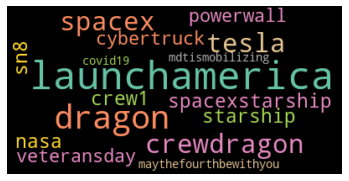

In [9]:
# Elon's hashtags

relavent_tags_elon = stats_coll.find({"user.screen_name" : "elonmusk", "hashtags": {'$exists': True, '$ne': [] }}) #query Mongo
out_elon = get_tags(relavent_tags_elon)

plot_hash_frq(out_elon[1], 0) #bar chart

plot_cloud(out_elon[0]) #word cloud


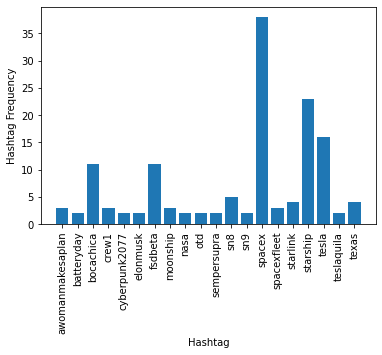

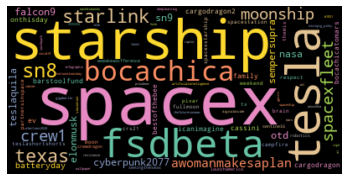

In [10]:
# Elon's favorites' hashtags

relavent_tags_favs = favs_coll.find({"favorited_by_screen_name": "elonmusk", "hashtags": {'$exists': True, '$ne': [] }})

out_favs = get_tags(relavent_tags_favs)

plot_hash_frq(out_favs[1]) #bar chart

plot_cloud(out_favs[0]) #word cloud

In [54]:
# supplementary metrics to look at possible topics to use for network analysis
num_tesla = out_favs[1]["tesla"]
num_spacex = out_favs[1]["spacex"]

all_favs = favs_coll.find({"favorited_by_screen_name": "elonmusk"})
all_count = all_favs.count()

print("%f percent of Elon's favorited tweets with hashtag 'tesla'" % ((num_tesla/all_count)*100))
print("%f percent of Elon's favorited tweets with hashtag 'spacex'" % ((num_spacex/all_count)*100))

1.353638 percent of Elon's favorited tweets with hashtag 'tesla'
3.214890 percent of Elon's favorited tweets with hashtag 'spacex'


<ipython-input-54-5655dc0acb2f>:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  all_count = all_favs.count()


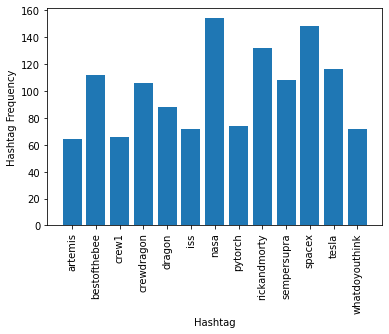

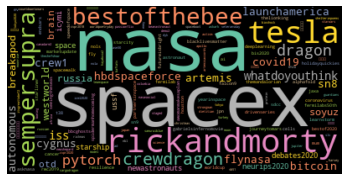

In [12]:
# Elon's friends hashtags

friends = friends_coll.find({"friend_of_screen_name": "elonmusk"})

tot_list = []

# iterate over all friend relationships with elon and pull hashtags for each
for f in friends:
    relavent_tags_friends = stats_coll.find({"user.screen_name" : f["screen_name"], "hashtags": {'$exists': True, '$ne': [] }})
    out = (get_tags(relavent_tags_friends))[0]
    tot_list = tot_list + out

# perform similar sorting as above but with full list of hashtags
tag_frq = {}
for v, f in groupby(sorted(tot_list)):
        tag_frq[v] = len(list(f))

plot_hash_frq(tag_frq, 60) #bar chart

plot_cloud(tot_list) #word cloud

## Section 3: Arango and Graph Analysis

In order to analyze Elon's network, I query all of his favorited tweets that have the key word of interest and then connect the outputs of friendships between the posters of those tweets.  I then calculate some metrics to characterize the graphs interconectedness and identify prominent users.

**Graph Description**: The Graph contains many types of nodes and labels which I will list below:
- Edges
    - Red: Favorited by Elon
    - Blue: Tweeted by user
    - Green: Mutual friend between users
- On status nodes: 
    - Hashtag, Text, or MentionL: describes context where keyword is found,
    - Number: ID number
- On user nodes:
    - Username
    - Engagement metric

In [13]:
# First we need to find Elon's ID to query

query_findelon = """FOR user IN users
    FILTER user.screen_name == 'elonmusk'
    RETURN user.user_id
    """

elon_results = db_arango.aql.execute(query_findelon)
for i in elon_results:
    elon_id = i

print(elon_id)

44196397


In [57]:

def find_paths(keyword, id_n):
    '''Executes Arango traversal to find all favorite tweets of a user including a key word, 
    and returns a combined set of nodes and edges for the tweets and users who wrote the tweets
    plus the individual raw output of seperate nodes and edges'''

    query = """FOR v,e,p IN 1..3 OUTBOUND 'users/""" + id_n + """' favorited
        FILTER CONTAINS(v.text, '""" + keyword + """') == True
        FOR status IN p.edges[*]._to
            FOR v2,e2,p2 IN 1..2 INBOUND status tweeted
            RETURN {"statuses_e": p.edges[*], "statuses_v": p.vertices[*], "users_e" : p2.edges[*], "users_v" : p2.vertices[*]}
        
        """

    output = db_arango.aql.execute(query) # execute query
    paths = list(output) # convert cursor

    out = []
    
    # append all output nodes and edges together
    for path in paths:
        tot = {}
        tot["edges"] = path['statuses_e'] + path['users_e']
        tot["vertices"] = path['statuses_v'] + path['users_v']
        out.append(tot)
        
    return (paths, out)




In [58]:
def get_names(paths):
    '''Takes in the edges from the second part of the query and identifies the mutual friends within the network'''
    sub_nodes = []
    out = []
    
    for path in paths:
        user = path['users_e'][0]['_from']
        sub_nodes.append(user)
    sub_nodes.append('users/44196397')
    
    for i in sub_nodes:
        for j in sub_nodes:
            if j == i:
                pass
            else:
                query = """FOR friendship IN friends
                    FILTER friendship._from == '""" + i + """'
                    FILTER friendship._to == '""" + j + """'
                    RETURN friendship"""
        
                friend_results = db_arango.aql.execute(query)
                output = list(friend_results)
                if len(output) > 0:
                    out.append(output[0])
    
    return out
                


In [59]:
# query specific key word and get interconnections (Example: NASA, but all you need to do is change the keyword to replicate results)
key_paths = find_paths('NASA', elon_id)
inter_cons = get_names(key_paths[0])

In [70]:

def calc_engagement(node):
    '''Uses the users reach based on their statuses, friends, and verification and calculates engagement using their number of retweets and favorites.'''
    
    # find retweets
    retweets = calc_retweets(node["screen_name"])
    
    # set multiplier to verified accounts
    if node["verified"] == 1:
        v = 1.10
    else:
        v = 1
    
    # calulate reach and engagement
    reach = (node["statuses_count"] + node["friends_count"])*v
    try:
        engagement = (int(retweets) + int(node["favorites_count"]))/reach
        return engagement
    except TypeError: 
        return 0


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 14));

# initialize graph
G = nx.Graph(ax=ax)

all_nodes = []

h_count = 0
m_count = 0
t_count = 0

for path in key_paths[1]:

    nodes = path['vertices']
    edges = path['edges']
    
    all_nodes = all_nodes + nodes

    # iterate over all edges and add them plus supplementary labelling to the graph
    for edge in edges:
        outbound = edge['_from']
        inbound = edge['_to']
        collection = (edge['_id'].split('/'))[0]
        for node in nodes:
            if node['_id'] == outbound:
                    en_met = calc_engagement(node)
                    root_node = node['screen_name'] + ": " + str(round(en_met, 2))
            if node['_id'] == inbound:
                    if ("#" + keyword) in node['text']:
                        dest_node = "Hashtag: " + node['status_id']
                        h_count +=1
                    elif ("@" + keyword) in node['text']:
                        dest_node = "Mention: " + node['status_id']
                        m_count +=1
                    else:
                        dest_node = "Plain Text: " + node['status_id']
                        t_count +=1
                    
        if collection == "favorited":
            color = "red"
        elif collection == "tweeted":
            color = "blue"
        
        G.add_edge(root_node, dest_node, color=color)

# add in mutual friend edges
edge_count = 0
for edge in inter_cons:
    outbound = edge['_from']
    inbound = edge['_to']
    for node in all_nodes:
        if node['_id'] == outbound:
            en_met = calc_engagement(node)
            root_node = node['screen_name'] + ": " + str(round(en_met, 2))
        if node['_id'] == inbound:
            en_met = calc_engagement(node)
            dest_node = node['screen_name'] + ": " + str(round(en_met, 2))
            
    G.add_edge(root_node, dest_node, color='green')
    edge_count += 1
     
edges = G.edges()
colors = nx.get_edge_attributes(G,'color').values() 

# Node type calculations
print("Number of mutual friends in network: %f" % edge_count)
print("Total status nodes in network %f" % (t_count+h_count+m_count))
print("Percent status nodes that are hashtags in network %f" % (h_count/(t_count+h_count+m_count)))
print("Percent status nodes that are mentions in network %f" % (m_count/(t_count+h_count+m_count)))

# Plotting the Network (Note: I used the same set up parameters alpha and k from class)
pos = nx.spring_layout(G, k=.01)
nx.draw_networkx_nodes(G, pos, node_color='grey', alpha=0.7, node_size=600)
nx.draw_networkx_edges(G, pos, edge_color=colors, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight='bold', font_size=12, font_color='black')

In [67]:
# Betweeness Centrality Calc
bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)

sort_bet_centrality = dict(sorted(bet_centrality.items(), key=lambda item: item[1]))

bc = list(sort_bet_centrality.keys())[-2]
print("Highest Betweeness centrality (besides Elon): %s, %f" % (hc, sort_bet_centrality[bc]))

# Degree Centrality Calc
deg_centrality = nx.degree_centrality(G)
sort_deg_centrality = dict(sorted(deg_centrality.items(), key=lambda item: item[1]))

hc = list(sort_deg_centrality.keys())[-2]
print("Highest Degree Centrality (besides Elon): %s, %f" % (hc, sort_deg_centrality[hc]))

# Density Calc
density = nx.density(G)
print("Graph Density: %f" % density)

Highest Betweeness centrality (besides Elon): Erdayastronaut, 0.073833
Highest Degree Centrality (besides Elon): Erdayastronaut, 0.157143
Graph Density: 0.046680
